# Extrapolating beyond the measurement range
This tutorial illustrates recovery and extrapolation of the DRT from truncated data.

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

from bayes_drt.inversion import Inverter
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

# 1. Load simulated data
For this example, we use data simulated from a circuit consisting of an ohmic resistance, a parallel resistor-inductor (RL) element, and two ZARC elements. The data is truncated such that the impedance responses of the high-frequency RL element and low-frequency ZARC element are not fully captured by the simulated experiment. Artifical noise from J.R. Macdonald's proportional error model (https://doi.org/10.1016/0013-4686(90)80002-6) was added. 

In [3]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [4]:
# load simulated data
circuit = 'trunc'
err_model = 'Macdonald'
noise_level = 0.25
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))
# load exact impedance over full frequency range
Zdf_full = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_noiseless_FullRange.csv'))
# make complex impedance array
Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values
# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


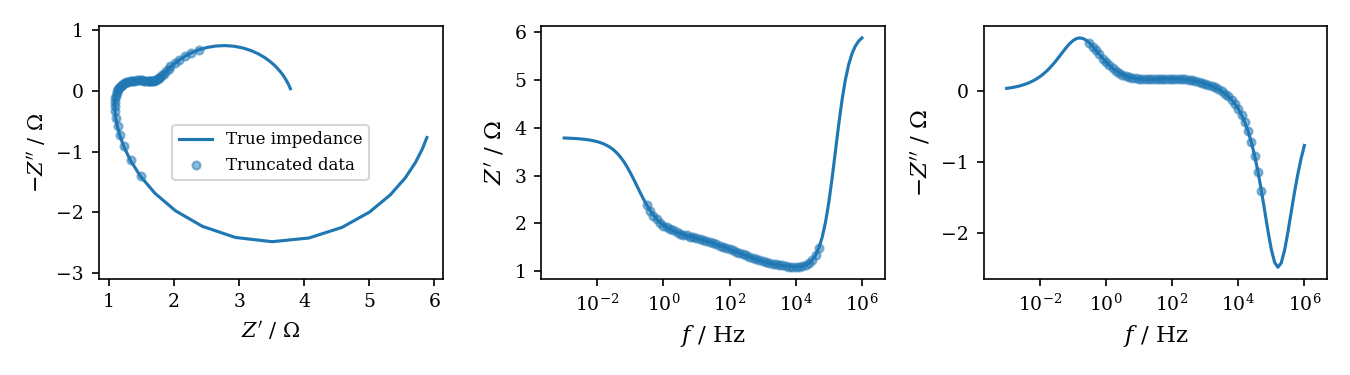

In [63]:
# plot the noisy impedance data
%matplotlib notebook
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5,label='Truncated data',eq_xy=False)
gt.plot_full_eis(Zdf_full,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot',label='True impedance')
fig.tight_layout()

# 2. Initialize an `Inverter` object
The data clearly contains truncated impedance features, suggesting that the underlying DRT must have density outside the bounds of the measured frequency range. Therefore, we need to use an expanded frequency range (or equivalently, time constant range) as the basis for the deconvolution. We can specify a custom basis frequency vector in the `basis_freq` argument. Visual inspection of the data suggests that the low-frequency feature may end near $10^{-2}$ Hz. The high-frequency feature is more severely truncated, so we choose to consider frequencies as high as $10^7$ Hz. The limits of the expanded basis frequency range do not need to be precise, so long as they are wide enough to capture all anticipated features in the DRT. 

**Important**: When specifying a custom basis frequency range, make sure that the basis frequencies/time constants are **logarithmically equispaced with 10 points per decade** (ppd). This is easy to achieve with `numpy.logspace`. The CHB model is calibrated for a basis frequency spacing of 10 ppd and a corresponding $\epsilon$ value of $\approx 4.34$ (calculated automatically); variations from these defaults can cause unexpected results. 

In [37]:
# Create Inverter instance with custom frequency range
# By convention, specify frequencies in descending order (although this is not required)
inv_hmc = Inverter(basis_freq=np.logspace(7,-2,91))

Let's check the result when we calculate the matrices required for fitting. (It's not necessary to run `_prep_matrices` manually - this is done automatically within the fitting methods - but we do so here to demonstrate the results when using custom basis frequencies).

In [38]:
start = time.time()
inv_hmc._prep_matrices(freq,Z,'both',weights=None,dZ=False,scale_Z=True,penalty='discrete',fit_type='map')
elapsed = time.time()-start
print('Matrix calculation time: {:.2f} s'.format(elapsed))

Matrix calculation time: 0.25 s


Here, even though the basis time constants are not simply the inverted measurement frequencies, the inverted measurement frequencies are a subset of the basis time constants, such that the $\mathbf{A}$ matrices are still Toeplitz matrices. Thus, the matrix calculation is relatively fast.

In [39]:
# View the resulting tau mesh and epsilon
inv_hmc.distributions

{'DRT': {'kernel': 'DRT',
  'dist_type': 'series',
  'tau': array([1.59154943e-08, 2.00364202e-08, 2.52243586e-08, 3.17555860e-08,
         3.99779142e-08, 5.03292121e-08, 6.33607241e-08, 7.97664256e-08,
         1.00419980e-07, 1.26421265e-07, 1.59154943e-07, 2.00364202e-07,
         2.52243586e-07, 3.17555860e-07, 3.99779142e-07, 5.03292121e-07,
         6.33607241e-07, 7.97664256e-07, 1.00419980e-06, 1.26421265e-06,
         1.59154943e-06, 2.00364202e-06, 2.52243586e-06, 3.17555860e-06,
         3.99779142e-06, 5.03292121e-06, 6.33607241e-06, 7.97664256e-06,
         1.00419980e-05, 1.26421265e-05, 1.59154943e-05, 2.00364202e-05,
         2.52243586e-05, 3.17555860e-05, 3.99779142e-05, 5.03292121e-05,
         6.33607241e-05, 7.97664256e-05, 1.00419980e-04, 1.26421265e-04,
         1.59154943e-04, 2.00364202e-04, 2.52243586e-04, 3.17555860e-04,
         3.99779142e-04, 5.03292121e-04, 6.33607241e-04, 7.97664256e-04,
         1.00419980e-03, 1.26421265e-03, 1.59154943e-03, 2.0036420

The basis frequencies were converted to a $\tau$ mesh, and an appropriate $\epsilon$ value was calculated. The $\epsilon$ value above - 4.3429... - is as expected, since we used a mesh with 10 ppd. As noted above, always use a mesh with 10 ppd and leave $\epsilon$ at its default setting for best results.

# 3. Fit the data
Now we're ready to fit the data with `bayes_fit` or `map_fit`. Since the data contains a resistive-inductive feature, we need to use `nonneg_drt=False` (the default setting).

In [41]:
# Perform HMC sampling with bayes_fit
start = time.time()
inv_hmc.bayes_fit(freq,Z)
elapsed = time.time() - start
print('HMC fit time: {:.2f} s'.format(elapsed))

HMC fit time: 140.86 s


The warnings above about Rhat and iterations saturating the maximum tree depth are fairly common when the noise level in the data is low and/or the model is complex. In general, they are not indicative of issues with the fit - just check your results. The Rhat values can be improved by increasing the number of samples with the `warmup` and `sample` parameters of `bayes_fit`, but this seems to almost always be unnecessary.

In [257]:
# Perform MAP optimization with map_fit
inv_map = Inverter(basis_freq=np.logspace(7,-2,91))
start = time.time()
inv_map.map_fit(freq,Z,inductance_scale=1e-6)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))
inv_map.inductance

MAP fit time: 16.48 s


7.086249333116663e-07

In [255]:
inv_map.inductance

1.278302113139899e-06

Here, `map_fit` is ~10 times faster than `bayes_fit`.

# 4. Visualize the fit and DRT
We use convenience functions defined below for plotting. For detail on how to extract the DRT and impedance fit from the `Inverter` instance, see the Simple ZARC tutorial.

In [67]:
# Convenience functions for visualization
def plot_drt_result(inv,Zdf,g_true,plot_ci=False,c='k',label=None,axes=None,plot_data=True):
    "Plot recovered DRT and impedance fit"
    if axes is None:
        fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    else:
        fig = axes.ravel()[0].get_figure()
    freq = Zdf['Freq'].values
    
    if label is None:
        Z_label = 'Fit'
        g_label = 'Recovered'
    else:
        Z_label = label
        g_label = label
    
    # plot noisy data
    if plot_data:
        gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = inv.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label=Z_label,bode_cols=['Zreal','Zimag'],
                     c=c,plot_func='plot')

    # plot the true DRT
    if plot_data:
        p = axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
        # add vertical line for RL element
        axes[1,1].plot([1e-6,1e-6],[0,-10],ls='--',lw=1,c=p[0].get_color())
        # plot data limits
        axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='gray',label='Data limits')
        axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='gray')
    # get the recovered DRT
    g_pred = inv.predict_distribution('DRT',g_true['tau'])
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if HMC sampling used
        g_lo = inv.predict_distribution('DRT',g_true['tau'],percentile=2.5)
        g_hi = inv.predict_distribution('DRT',g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color=c,label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label=g_label,alpha=0.8)
        
    # plot zero line
    for ax in [axes[0,0],axes[1,0],axes[1,1]]:
        ax.axhline(0,c='k',lw=0.5,zorder=-10)
        
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \Omega$')
    axes[1,1].set_ylim(-4.5,2)

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()
    return axes

def plot_resid(inv,Zdf):
    "Plot residuals and recovered error scale"
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = inv.predict_Z(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Zc)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

    # plot true error scale
    p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
    axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
    axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
    axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())
    
    # plot zero line
    for ax in axes:
        ax.axhline(0,c='k',lw=0.5,zorder=-10)

    # get the recovered error scale
    sigma_re, sigma_im = inv.predict_sigma(freq)
    # plot recovered error scale
    axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    
    fig.tight_layout()
    return axes

First, let's look at the HMC result.

<IPython.core.display.Javascript object>


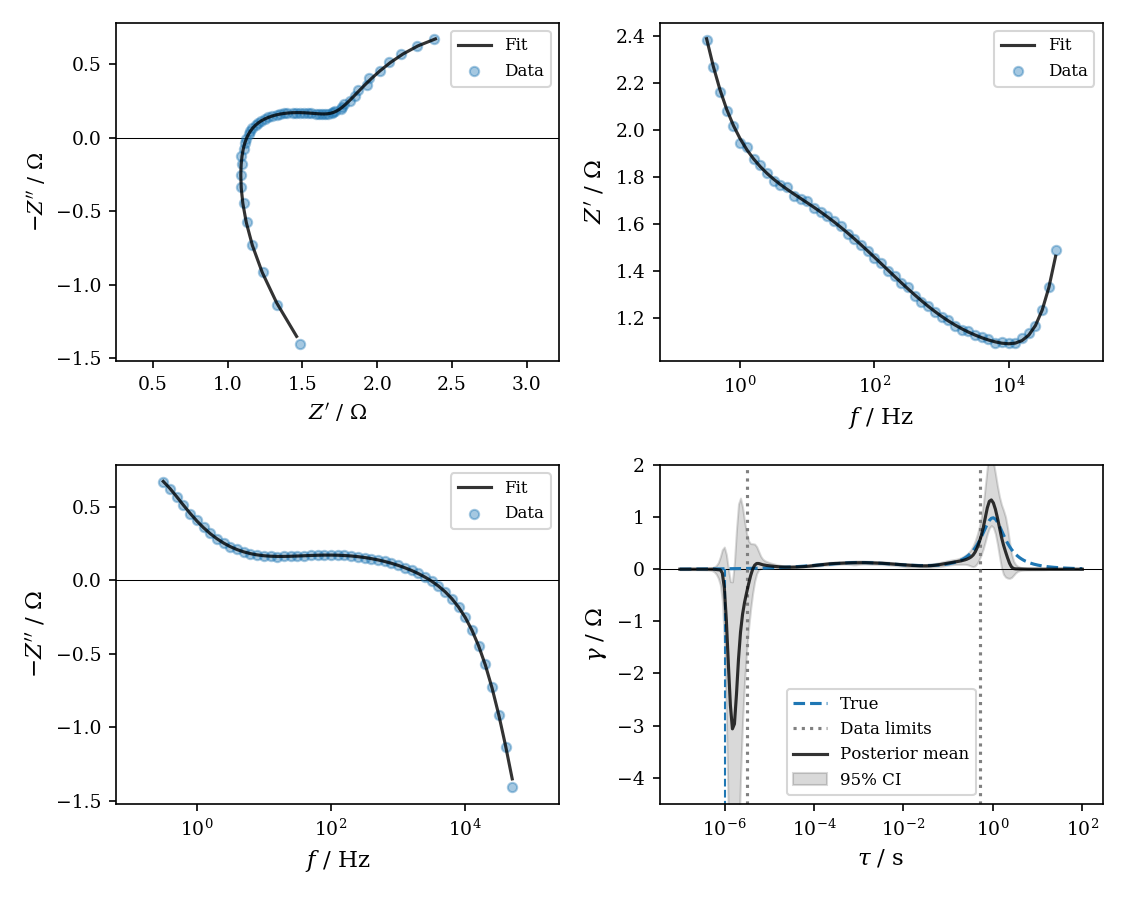

In [68]:
# plot DRT and impedance fit
axes = plot_drt_result(inv_hmc,Zdf,g_true,plot_ci=True)

<IPython.core.display.Javascript object>


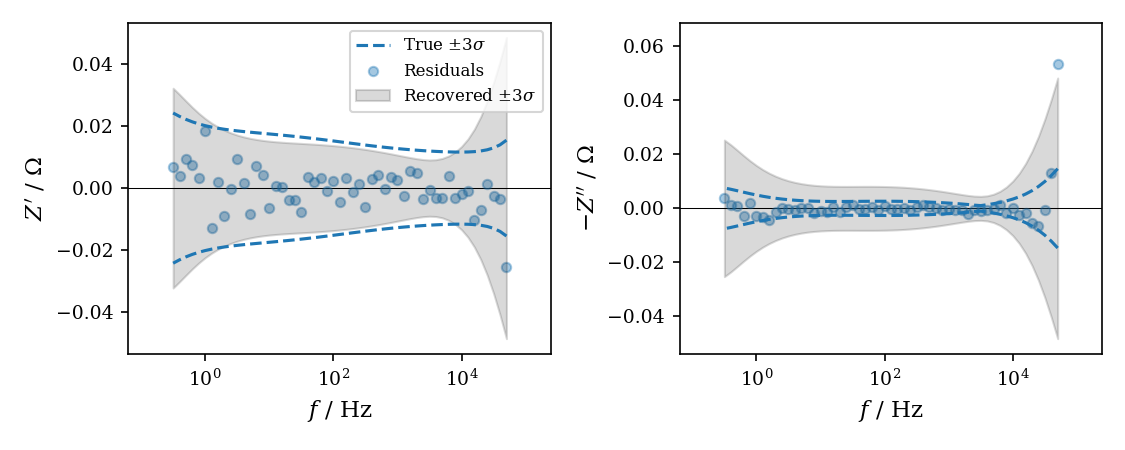

In [59]:
# plot residuals and error scale
axes = plot_resid(inv_hmc,Zdf)

The HMC fit provides a good estimate of all features in the DRT, despite the truncation of the data. The RL element at $10^{-6}$ Hz is represented by an infinite Dirac delta function in the DRT, which cannot be recovered exactly, but is reasonably represented by a large negative peak in the recovered DRT. The HMC result also recovers the low-frequency ZARC element, although the recovered DRT relaxes to zero prematurely. The credible interval (CI) indicates higher uncertainty immediately outside the measured frequency range, but indicates that there is high certainty that the DRT relaxes to zero at timescales well outside the measured range.

The recovered error scale indicates that the model overestimates the error scale at high frequencies, especially for the imaginary part of the impedance. However, the shape of the error structure is qualitatively accurate.

Next, let's look at the MAP results.

<IPython.core.display.Javascript object>


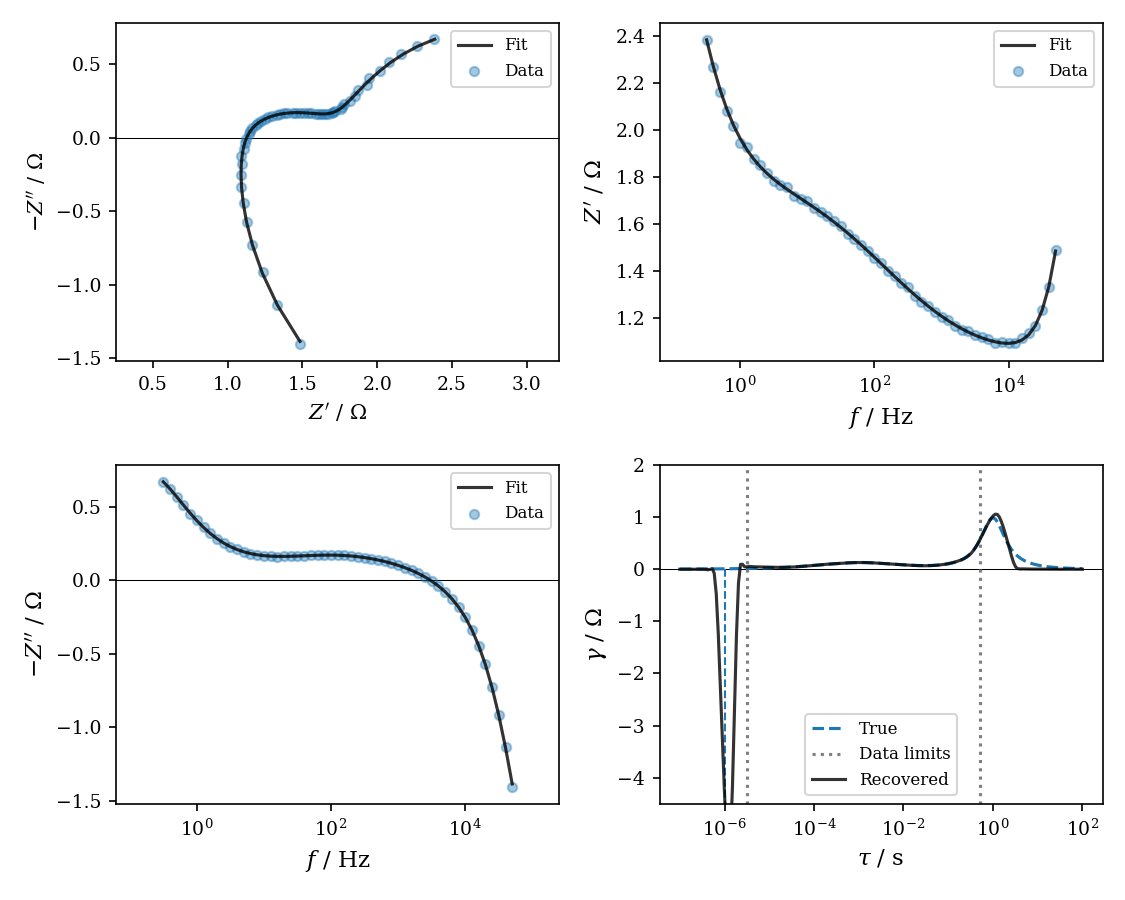

In [258]:
# plot DRT and impedance fit
axes = plot_drt_result(inv_map,Zdf,g_true,plot_ci=False)

<IPython.core.display.Javascript object>


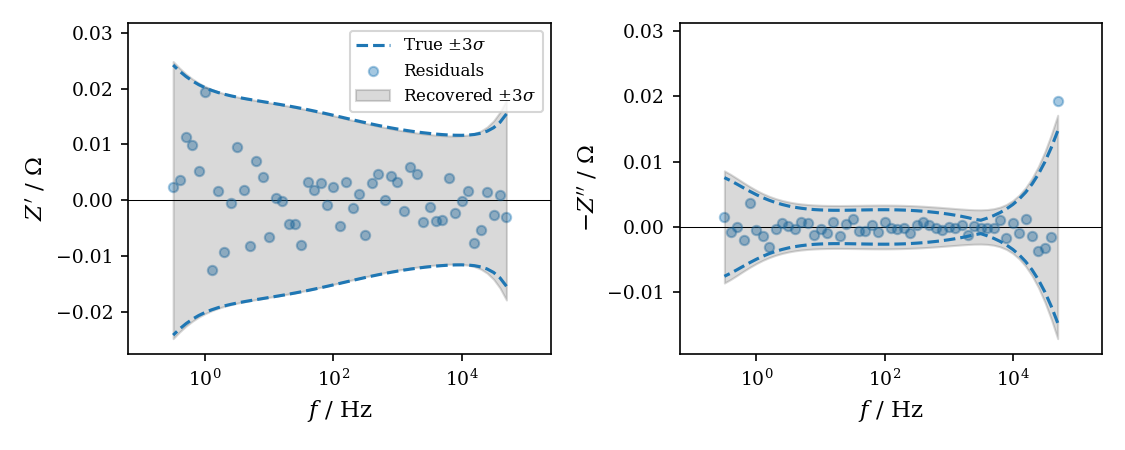

In [259]:
# plot residuals and error scale
axes = plot_resid(inv_map,Zdf)

The MAP fit produces a better reconstruction of the high-frequency RL element (larger/sharper peak), and a similar reconstruction of the low-frequency ZARC element. This is reflected in the improved estimate of the error structure, which is both qualitatively and quantitatively accurate.

# 5. Extrapolate the impedance

The `Inverter` object can be used to extrapolate the impedance beyond the measured frequency range by supplying a custom frequency range to the `predict_Z` method. First, let's look at the HMC prediction, which provides a credible interval.

<IPython.core.display.Javascript object>


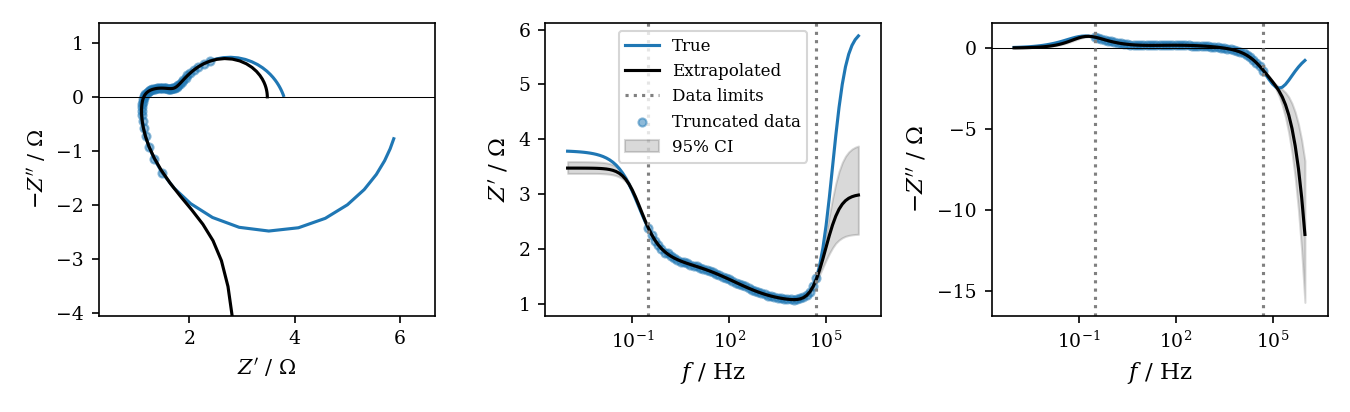

In [235]:
"Extrapolate the impedance using the HMC fit"
freq_full = Zdf_full['Freq'].values
Z_extrap = inv_hmc.predict_Z(freq_full)
df_extrap = gt.construct_eis_df(freq_full,Z_extrap)

# Calculate CIs for real and imag impedance
Z_lo = inv_hmc.predict_Z(freq_full,percentile=2.5)
Z_hi = inv_hmc.predict_Z(freq_full,percentile=97.5)

fig,axes = plt.subplots(1,3,figsize=(9,2.75))

# plot true impedance
gt.plot_full_eis(Zdf_full,plot_func='plot',label='True',axes=axes,bode_cols=['Zreal','Zimag'])
# plot truncated data
gt.plot_full_eis(Zdf,label='Truncated data',axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
# plot mean predicted impedance
gt.plot_full_eis(df_extrap,label='Extrapolated',plot_func='plot',axes=axes,bode_cols=['Zreal','Zimag'],c='k')

# plot CIs on Bode plots
axes[1].fill_between(freq_full,Z_lo.real,Z_hi.real,color='k',alpha=0.15,label='95% CI')
axes[2].fill_between(freq_full,-Z_lo.imag,-Z_hi.imag,color='k',alpha=0.15)

for ax in [axes[0],axes[2]]:
    # mark zero line
    ax.axhline(0,c='k',lw=0.5)
for ax in axes[1:]:
    # plot data limits
    ax.axvline(Zdf['Freq'].min(),ls=':',c='gray',label='Data limits')
    ax.axvline(Zdf['Freq'].max(),ls=':',c='gray')
    
axes[0].get_legend().remove()
axes[1].legend()

The model extrapolates the low-frequency impedance fairly accurately, but slightly underestimates the low-frequency intercept. However, the extrapolated impedance in the high-frequency region reveals that the model uses a combination of pure inductance and a resistive-inductive DRT feature to fit the impedance response of the RL element, resulting in a large deviation from the true $Z^{\prime\prime}$ at high frequencies. This is difficult to avoid given the small number of measured data points describing the RL element; the model inherently favors using pure inductance and pure (ohmic) resistance to fit the impedance rather than increasing density in the DRT, such that a combination of inductance and moderate negative density in the DRT is more probably than large negative density in the DRT. If there were more data points defining the RL element, the stronger evidence in the data would allow for a larger negative spike in the DRT and a corresponding reduction in the pure inductance. However, as seen in the Nyquist plot, the measurement captures less than one quarter of the RL semicircle, resulting in a high degree of ambiguity.

The CIs in the Bode plots show that the CI is very narrow within the measured frequency range, but widens significantly outside the measurement range, as expected. Displaying a CI in the Nyquist representation is challenging, but we present one workaround in the next section.

We can also extrapolate using the MAP fit, as shown below.

<IPython.core.display.Javascript object>


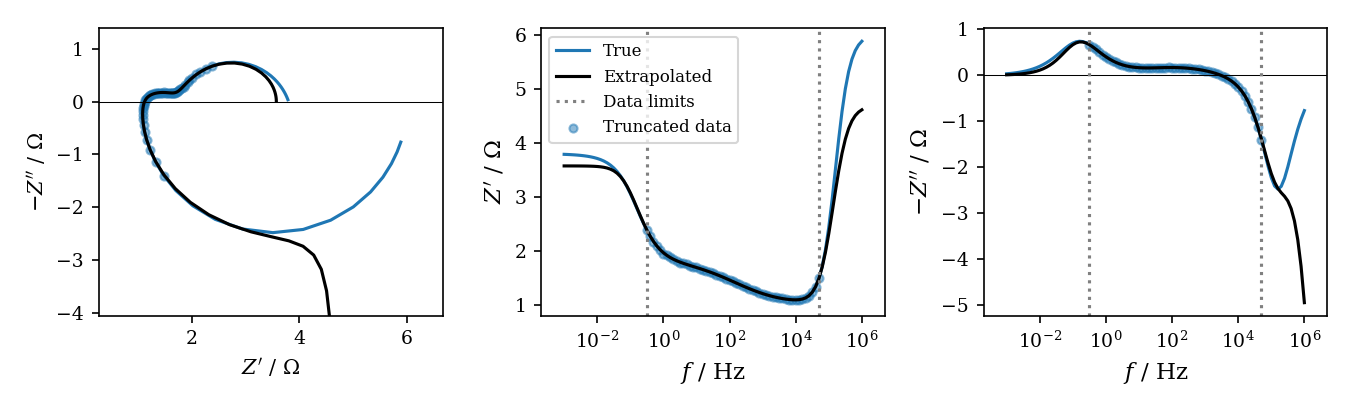

In [260]:
"Extrapolate the impedance using the MAP fit"
freq_full = Zdf_full['Freq'].values
Z_extrap = inv_map.predict_Z(freq_full)
df_extrap = gt.construct_eis_df(freq_full,Z_extrap)

fig,axes = plt.subplots(1,3,figsize=(9,2.75))

# plot true impedance
gt.plot_full_eis(Zdf_full,plot_func='plot',label='True',axes=axes,bode_cols=['Zreal','Zimag'])
# plot truncated data
gt.plot_full_eis(Zdf,label='Truncated data',axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
# plot mean predicted impedance
gt.plot_full_eis(df_extrap,label='Extrapolated',plot_func='plot',axes=axes,bode_cols=['Zreal','Zimag'],c='k')

for ax in [axes[0],axes[2]]:
    # mark zero line
    ax.axhline(0,c='k',lw=0.5)
for ax in axes[1:]:
    # plot data limits
    ax.axvline(Zdf['Freq'].min(),ls=':',c='gray',label='Data limits')
    ax.axvline(Zdf['Freq'].max(),ls=':',c='gray')
    
axes[0].get_legend().remove()
axes[1].legend()

The MAP fit extrapolates both the low- and high-frequency impedance responses slightly more accurately than the HMC fit.

Both the HMC and MAP results provide reasonable extrapolations of the impedance given the degree of data truncation.

# 6. Visualizing uncertainty in the Nyquist representation

As noted above, displaying CIs in the Nyquist representation is challenging, as $Z^\prime$ and $Z^{\prime\prime}$ are correlated. Rather than displaying a continuous band for the CI, we can use the HMC samples to evaluate the posterior distribution of the impedance at each frequency. The `Inverter` class provides the `predict_Z_distribution` method for this purpose. The impedance distribution for each frequency can then be displayed as a scatter plot, as shown below.

<IPython.core.display.Javascript object>


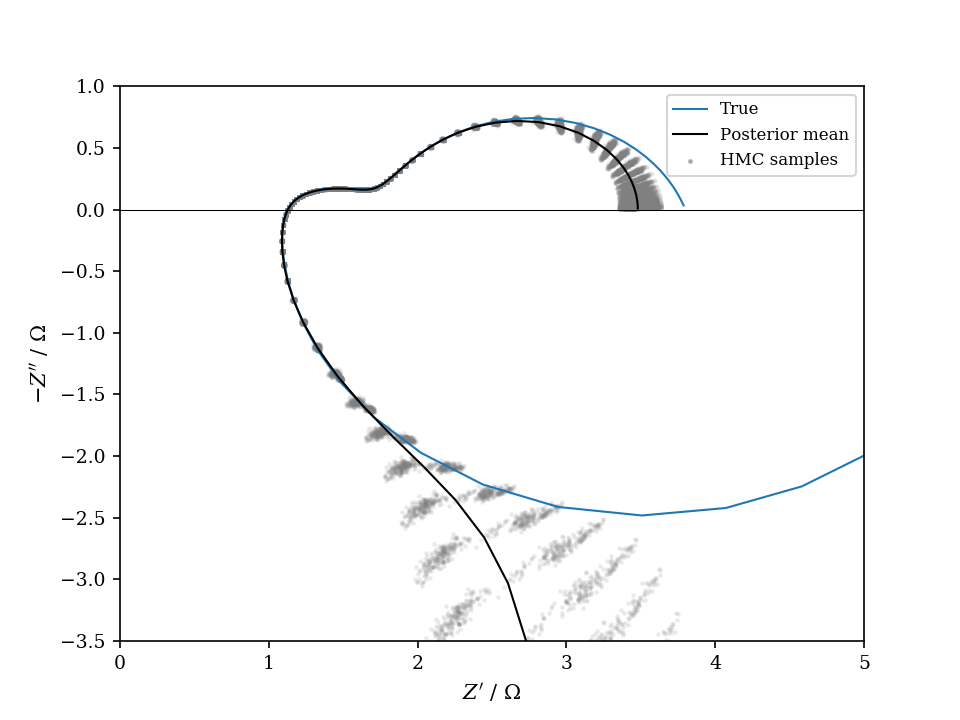

Number of samples: 400


In [246]:
# use the HMC samples to calculate Z samples
Z_pred_matrix = inv_hmc.predict_Z_distribution(freq_full)
# predict posterior mean
Z_pred_mean = inv_hmc.predict_Z(freq_full)
df_mean = gt.construct_eis_df(freq_full,Z_pred_mean)

fig,ax = plt.subplots()

# plot the true impedance
gt.plot_nyquist(Zdf_full,plot_func='plot',label='True',ax=ax,lw=1)
# plot the posterior mean predicted impedance
gt.plot_nyquist(df_mean,plot_func='plot',label='Posterior mean',ax=ax,lw=1,c='k')

# each row of Z_pred_matrix is a sample. Plot each sample
print('Number of samples: {}'.format(Z_pred_matrix.shape[0]))
for i,Zp in enumerate(Z_pred_matrix):
    df = gt.construct_eis_df(freq_full,Zp)
    if i==0:
        label='HMC samples'
        # Make first sample darker for legend visibility
        alpha=0.5
    else:
        label=''
        alpha=0.1
    gt.plot_nyquist(df,ax=ax,s=2,alpha=alpha,c='gray',label=label)
    
ax.set_xlim(0,5)
ax.set_ylim(-3.5,1)
ax.axhline(0,c='k',lw=0.5)
ax.legend()

The Nyquist visualization reveals an interesting feature - at high frequencies, the impedance distribution becomes bimodal. This is an artifact of the frugal sampling scheme: we used two HMC chains, each of which sampled 200 iterations. It appears that the two chains diverge at high frequencies, resulting in a wide apparent CI. This reflects the warning that `Stan` gave us during HMC sampling - Rhat values far from 1 indicate that the chains did not mix (i.e., they did not converge to the same parameter space). It's possible that increasing the number of sampling iterations and/or the number of chains would resolve this issue. However, there is a very large degree of ambiguity in the high-frequency DRT due to both the data truncation and the potential for tradeoff between pure inductance and resistive-inductive DRT density, which may make it difficult to arrive at well-mixed chains for this spectrum.